# Lab 1: Extreme Quantization

### Introduction

Deep neural networks are often large and computationally expensive, especially when trained and stored in floating-point format. Although 8-bit quantization has become an industry-standard approach for reducing model size and improving efficiency, it has been shown in research that even lower-bit formats can show an increased accuracy-to-memory trade-off. This leads us into the realm of **extreme quantization**, where parameters (and sometimes activations) are quantized to 4 bits, 2 bits, or even a single bit (binary networks).

By pushing below 8 bits, the potential gains in memory footprint and inference speed can be enormous. For instance, a binary network may require as little as 1 bit per weight, cutting the size by a factor of 32 compared to a typical FP32 model. The computational speedups come from the possibility of using bitwise operations (like XNOR and popcount) or small lookup tables (LUTs) for matrix multiplications, which can outperform standard floating-point arithmetic on many Arm-based systems. However, accuracy often suffers without special training or architectural modifications, and not all libraries offer robust support for sub-8-bit kernels.

This lab offers a hands-on exploration of these trade-offs. We will begin by training baseline floating-point (FP32) model, then progressively quantize it to 8 bits, 4 bits, 2 bits, and finally 1 bit. Along the way, you will see how each step impacts model size, computational efficiency, and accuracy. Although we will not implement custom kernels in this lab, we will discuss how bitwise or LUT-based operations achieve speed gains on modern hardware. Our ultimate goal is to develop an intuition for when and why extreme quantization is useful, and to motivate more advanced techniques—such as quantization-aware training—in subsequent labs and inspire you to develope, new and imprved extremely quantized models

### Lab Objectives

1. Demonstrate the practical impact of going from 8-bit down to 1-bit quantization in terms of model size, speed, and accuracy.  
2. Discuss how bitwise operations or lookup tables (LUTs) offer significant performance advantages for ultra-low-precision arithmetic.  
3. Identify common pitfalls of extreme quantization and why accuracy degrades sharply without specialized training methods.  
4. Lay the groundwork for future labs on quantization-aware training and custom operator design.

By the end of this lab, you will have a clearer picture of the benefits and limitations of extreme quantization, helping you understand how to balance efficiency and performance in real-world deployments on resource-constrained Arm devices.

---

## Training your own Vision Transformer

lets start by training your own vision transformer on the popular cifar10 dataset. Once we have done so we can play with quantizing the model, post-training. This is a popular technique as, post-training quantization avoids the need to retrain the model, avoiding a computationally expensive step. 

In [2]:
import torch
from vit_pytorch import ViT

vit = ViT(
    image_size = 32,     # CIFAR-10 images are 32x32
    patch_size = 4,      # The size of the image path split into a single token
    num_classes = 10,    # The number of classes in the dataset
    dim = 512,           # The inner dimension of the model (number of channels in the tokens)
    depth = 6,           # The number of transformer blocks
    heads = 8,           # The number of attnetion heads per transformer block 
    mlp_dim = 1024,      # The feedforward dimension of the MLP
    dropout = 0.1,       # The dropout rate for the transformer
    emb_dropout = 0.1    # The dropout rate for the embedding
)

img = torch.randn(1, 3, 32, 32)

preds = vit(img) 
print("preds.shape", preds.shape)

preds.shape torch.Size([1, 10])


In [3]:
from src.lab1.cifar10_trainer import CIFAR10Module, PlotlyCallback
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

module = CIFAR10Module(
    model=vit,                                         # the model to train 
    learning_rate=1e-4,                                # the learning rate for the optimizer
    batch_size=128                                     # the batch size for the dataloader
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',                                 # the metric to monitor 
    mode='max',                                        # the mode to use for the monitor
    save_top_k=1,                                      # the number of top models to save
    save_last=True,                                    # whether to save the last model
    dirpath='./src/lab1/checkpoints',                 # the path to save the model during training
    filename='best'                                    # save the best model as 'best.ckpt'
)

trainer = pl.Trainer(
    max_epochs=10,                                      # the number of epochs to train for
    callbacks=[PlotlyCallback(), checkpoint_callback],  # the callbacks to use during training
    accelerator="auto",                                 # the accelerator to use during training
    devices="auto",                                     # the devices to use during training
    precision=16                                        # the precision to use during training
)
trainer.fit(module)

Files already downloaded and verified


Epoch 9: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s, v_num=10, train_loss=1.390, val_loss=1.090, val_acc=0.620]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 391/391 [00:20<00:00, 19.32it/s, v_num=10, train_loss=1.390, val_loss=1.090, val_acc=0.620]


#### Whilst your model is training, let’s take a deeper look at the theory of quantization with a hardware perspective. 

To understand, why quantization is such an effective approach for reducing memory consumption and latency of neural networks, we should take a look at the fundamental operation. The matrix multiply. 

##### A naive approach 

In [8]:
import numpy as np 
import torch 

M, N, K = 10, 32, 64

X = torch.randn(M, K) # initialize the activation matrix in memory 
W = torch.randn(K, N) # initialize the weight matrix in memory
Y = torch.empty(M, N) # allocate the output matrix memory 

for m in range(M): 
    for n in range(N): 
        acc = 0 # initialise the accumulator (in a fast register)
        for k in range(K): 
            x = X[m, k] # read the activation from memory 
            w = W[k, n] # read the weight from memory 
            acc += x * w  # perform the multiply-accumulate operation
        Y[m, n] = acc # write the result to memory 

assert torch.allclose(Y, torch.matmul(X, W), rtol=1e-3)


### Matrix Multiplication: Loop Structure and Compute Breakdown

In this example, we analyze a matrix multiplication kernel with three nested loops corresponding to the dimensions **M**, **N**, and **K**:

- **Outer loops** iterate over the **M** (rows of output) and **N** (columns of output) dimensions.
- **Inner loop** iterates over the **K** dimension and performs the core computation.

The innermost loop executes a **multiply-accumulate (MAC)** operation — the fundamental unit of matrix multiplication.

---

#### Each MAC Operation Consists of:

- 🔁 **Two memory reads**:  
  - Load element `x[m][k]`  
  - Load element `w[k][n]`
  
- ✖️ **One multiplication**:  
  - `x[m][k] * w[k][n]`
  
- ➕ **One addition**:  
  - Accumulate into the result: `acc[m][n] += ...`

---


Two key factors limit the speed of matrix multiplication: (1) how fast activations and weights can be fetched from memory, and (2) how quickly multiply-accumulate operations can be performed. These are governed by **memory bandwidth** and **compute throughput**, respectively — the latter typically measured in **TOPS** (Tera Operations Per Second). However, hardware trends consistently show that compute capabilities (TOPS/FLOPS) are improving at a significantly faster rate than memory bandwidth. As a result, **memory bandwidth is increasingly becoming the primary bottleneck** for neural network inference.

This is clearly illustrated in the figure below: while the performance of floating-point operations (grey line) continues to scale rapidly, both interconnect bandwidth (blue) and system memory bandwidth (green) lag behind. Consequently, **efficient memory access patterns and compression strategies** are becoming essential to reduce latency and improve throughput.

his constraint is even more critical in light of emerging [*inference-time scaling laws*](https://cdn.openai.com/papers/trading-inference-time-compute-for-adversarial-robustness-20250121_1.pdf), which suggest that large models — particularly those used for reasoning and decision-making — exhibit higher accuracy when more compute is allocated at inference time. Thus, optimizing memory usage is not just a systems concern, but a foundational enabler of next-generation model capabilities.

![alt text](./assets/lab1/bandwidth_vs_flops.png)

<center>Gholami, Amir, et al. "AI and memory wall." IEEE Micro, 2024.</center>






##### So how can we reduce the memory bandwith load caused by 
 
 ```python
  x = X[m, k]
  w = W[k, n]
  ...
  y = accum 
 ```

 One obvious solution is to reduce the size of the memory read, and writes ( ```x```/```w```, ```y```) which can be achieved by reducing the numerical precision of the weights and activations, allowing reduced bit-width representation of the data-types. In edge AI, it is common to use [*8-bit integer quantization*](https://arxiv.org/pdf/2106.08295) for weight and/or activations and often results in negligible accuracy loss, and offers a 4x reduction in memory bandwidth load over the standard fp32 precision. However, further gains can be made by using lower bit-width representations, such as 4-bit, 2-bit, and 1-bit. Despite the loss in precision, these models can still achieve high accuracy, and offer a significant reduction in memory bandwidth load.

 Let's examine asymmetric linear quantization, which maps floating point values to integers while accounting for potentially asymmetric distributions. For a bit-width of $b$, integers can represent $2^b$ distinct values, ranging from $-2^{b-1}$ to $2^{b-1} - 1$. An 8-bit signed integer spans [-128, 127], while float16 covers a much wider range.

 <center>![alt text](./assets/lab1/integer_format.png)</center>

 The asymmetric linear quantization process involves two key parameters:
 - Scale factor ($s$): determines the step size between quantization levels
 - Zero-point ($z$): shifts the quantization range to better match asymmetric distributions

 For a floating point value $r$, the quantized integer value $q$ is computed as:

 $$
 q = \text{round}\left(\frac{r}{s}\right) + z
 $$

 And the inverse operation (dequantization) is:

 $$
 r = s(q - z)
 $$

 The scale and zero-point are typically computed from the observed range of values:

 $$
 s = \frac{r_{max} - r_{min}}{q_{max} - q_{min}}
 $$

 $$
 z = \text{round}\left(q_{max} - \frac{r_{max}}{s}\right)
 $$

 <center><img src="./assets/lab1/linear_quant.png" width="900"/></center>

 This asymmetric approach allows for more efficient use of the available quantization levels compared to symmetric quantization, particularly when dealing with activation functions like ReLU that produce non-negative outputs or weight distributions that are not centered around zero. We can implement this in pytorch as follows: 



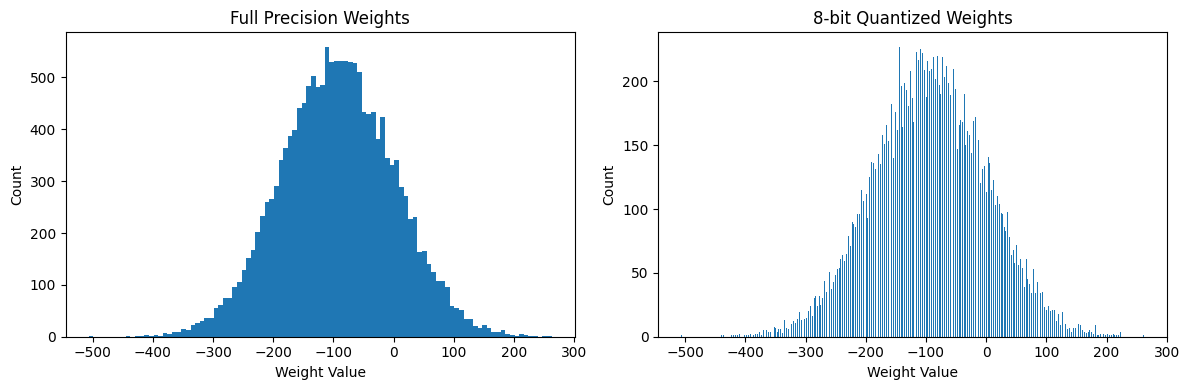

In [49]:
w = torch.randn(128, 128)*torch.rand(1)*100 + torch.randn(1)*100

def compute_linear_scale_and_zero_point(r, bitwidth=8):
    r_min = r.min()
    r_max = r.max()
    # For signed integers, range is [-2^(b-1), 2^(b-1)-1]
    q_min = -(2**(bitwidth - 1))  # Changed from positive to negative
    q_max = 2**(bitwidth - 1) - 1
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = torch.round(q_min - (r_min / scale))
    return scale, zero_point
 
def quantize_linear(x, scale, zero_point, bitwidth=8):
    q_min = -(2**(bitwidth - 1))
    q_max = 2**(bitwidth - 1) - 1
    q = torch.clamp(torch.round(x / scale) + zero_point, q_min, q_max)
    # Use appropriate dtype based on bitwidth
    if bitwidth <= 8:
        return q.to(torch.int8)
    elif bitwidth <= 16:
        return q.to(torch.int16)
    else:
        return q.to(torch.int32)
    
def dequantize_linear(q, scale, zero_point):
    return scale * (q.to(torch.float32) - zero_point)  # Reordered for clarity
    

s, z = compute_linear_scale_and_zero_point(w)
q_w = quantize_linear(w, s, z)
d_w = dequantize_linear(q_w, s, z)

import matplotlib.pyplot as plt
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot full precision weights
ax1.hist(w.flatten().numpy(), bins=100)
ax1.set_title('Full Precision Weights')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Count')

# Plot quantized weights
ax2.hist(d_w.flatten().numpy(), bins=500)
ax2.set_title('8-bit Quantized Weights')
ax2.set_xlabel('Weight Value') 
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()



We can get a measure of the quantization error using the frobenius norm. 

In [50]:
def compute_quantization_error(w, d_w): 
    return torch.norm(w - d_w, p='fro')

compute_quantization_error(w, d_w)

tensor(111.2507)

So lets get a look at how the bit-width of affects the quantization error. 

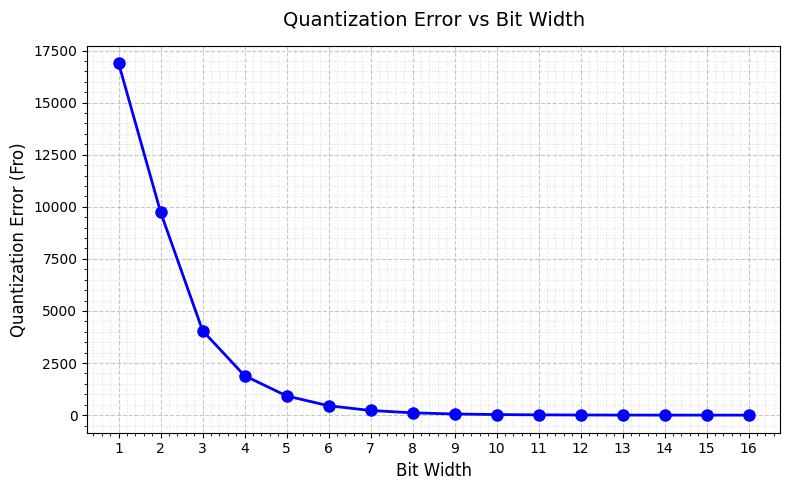

In [51]:
errors = []
for b in range(1, 17): 
    s, z = compute_linear_scale_and_zero_point(w, b)
    q_w = quantize_linear(w, s, z, b)
    d_w = dequantize_linear(q_w, s, z)
    errors.append(compute_quantization_error(w, d_w))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 17), errors, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Bit Width', fontsize=12)
plt.ylabel('Quantization Error (Fro)', fontsize=12)
plt.title('Quantization Error vs Bit Width', fontsize=14, pad=15)
plt.xticks(range(1, 17))

# Optional: Add minor gridlines for more precision
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()

# Optionally adjust margins
plt.tight_layout()

plt.show()

We can see that at higher bit-widths the quantization error is lower, and above 8-bits the error is close to 0. Therefore there will be margninal gains from increasing the bit-wdith past 8-bits. Lets test this out on your model to see if this is the case. 

In [ ]:
import torch.nn as nn 


class QLinear(nn.Module): 
    def __init__(self, in_features, out_features, bitwidth=8): 
        super(QLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features), dtype=torch.float32) 
        self.bias = nn.Parameter(torch.randn(out_features), dtype=torch.float32)
        self.bitwidth = bitwidth
        self.scale, self.zero_point = compute_linear_scale_and_zero_point(torch.randn(in_features, out_features), bitwidth)

    def foward(self, x): 
        d_x = dequantize_linear(self.weight, self.scale, self.zero_point)


    def get_dtype(self): 
        

        

In [ ]:
from src.lab1.cifar10_trainer import CIFAR10Module

module = CIFAR10Module.from_checkpoint("lab1/checkpoints/best.ckpt")